**Differential Calculus**

Calculus is the study of continuous change. It has two major subfields: differential calculus, which studies the rate of change of functions, and integral calculus, which studies the area under the curve. In this notebook, we will discuss of diffrential calculsthe former.

Differential calculus is at the core of Deep Learning, so it is important to understand what derivatives and gradients are, how they are used in Deep Learning, and understand what their limitations are.

Note: the code in this notebook is based on differential_calculus notebook from (c) ageron

# Slope of a straight line

In [ ]:
#@title
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

What is the slope of the following line?

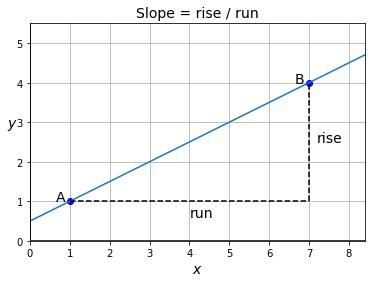

In [ ]:
#@title
def get_AB_line(A_pos, B_pos, x_min=-1000, x_max=+1000):
    rise = B_pos[1] - A_pos[1]
    run = B_pos[0] - A_pos[0]
    slope = rise / run
    offset = A_pos[1] - slope * A_pos[0]
    return [x_min, x_max], [x_min * slope + offset, x_max * slope + offset]

def plot_AB_line(A_pos, B_pos, A_name="A", B_name="B"):
    for point, name in ((A_pos, A_name), (B_pos, B_name)):
        plt.plot(point[0], point[1], "bo")
        plt.text(point[0] - 0.35, point[1], name, fontsize=14)
    xs, ys = get_AB_line(A_pos, B_pos)
    plt.plot(xs, ys)

def plot_rise_over_run(A_pos, B_pos):
    plt.plot([A_pos[0], B_pos[0]], [A_pos[1], A_pos[1]], "k--")
    plt.text((A_pos[0] + B_pos[0]) / 2, A_pos[1] - 0.4, "run", fontsize=14)
    plt.plot([B_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], "k--")
    plt.text(B_pos[0] + 0.2, (A_pos[1] + B_pos[1]) / 2, "rise", fontsize=14)

def show(axis="equal", ax=None, title=None, xlabel="$x$", ylabel="$y$"):
    ax = ax or plt.gca()
    ax.axis(axis)
    ax.grid()
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14, rotation=0)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

A_pos = np.array([1, 1])
B_pos = np.array([7, 4])
plot_AB_line(A_pos, B_pos)
plot_rise_over_run(A_pos, B_pos)
show([0, 8.4, 0, 5.5], title="Slope = rise / run")

As you probably know, the slope of a (non-vertical) straight line can be calculated by taking any two points $\mathrm{A}$ and $\mathrm{B}$ on the line, and computing the "rise over run":

$slope = \dfrac{rise}{run} = \dfrac{\Delta y}{\Delta x} = \dfrac{y_\mathrm{B} - y_\mathrm{A}}{x_\mathrm{B} - x_\mathrm{A}}$


In this example, the rise is 3, and the run is 6, so the slope is 3/6 = 0.5.

# Defining the slope of a curve

But what if you want to know the slope of something else than a straight line? For example, let's consider the curve defined by $y = f(x) = x^2$:

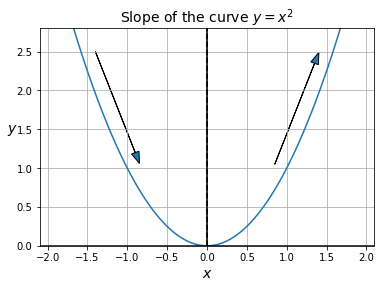

In [ ]:
#@title
xs = np.linspace(-2.1, 2.1, 500)
ys = xs**2
plt.plot(xs, ys)

plt.plot([0, 0], [0, 3], "k--")
plt.arrow(-1.4, 2.5, 0.5, -1.3, head_width=0.1)
plt.arrow(0.85, 1.05, 0.5, 1.3, head_width=0.1)
show([-2.1, 2.1, 0, 2.8], title="Slope of the curve $y = x^2$")

Obviously, the slope varies: on the left (i.e., when $x<0$), the slope is negative (i.e., when we move from left to right, the curve goes down), while on the right (i.e., when $x>0$) the slope is positive (i.e., when we move from left to right, the curve goes up). At the point $x=0$, the slope is equal to 0 (i.e., the curve is locally flat). The fact that the slope is 0 when we reach a minimum (or indeed a maximum) is crucially important, and we will come back to it later.

How can we put numbers on these intuitions? Well, say we want to estimate the slope of the curve at a point $\mathrm{A}$, we can do this by taking another point $\mathrm{B}$ on the curve, not too far away, and then computing the slope between these two points:


In [ ]:
#@title
def animate_AB_line(f, fp, f_str, x_A, axis=None):
    y_A = f(x_A)
    eps = 1e-4
    x_B_range = 1.5
    x_B = x_A + eps

    n_frames = 200
    text_offset_A = -0.2
    text_offset_B = +0.1
    x_min, x_max = -1000, 1000

    fig, ax = plt.subplots()

    # plot f(x)
    xs = np.linspace(-2.1, 2.1, 500)
    ys = f(xs)
    ax.plot(xs, ys)

    # plot the tangent to the curve at point A
    if fp:
        slope = fp(x_A)
        offset = y_A - slope * x_A
        ax.plot([x_min, x_max], [slope*x_min + offset, slope*x_max + offset],
                "y--")

    # plot the line AB and the labels A and B so they can be animated
    y_A = f(x_A)
    y_B = f(x_B)
    xs, ys = get_AB_line([x_A, y_A], [x_B, y_B])
    line_inf, = ax.plot(xs, ys, "-")
    line_AB, = ax.plot([x_A, x_B], [y_A, y_B], "bo-")
    ax.text(x_A + text_offset_A, y_A, "A", fontsize=14)
    B_text = ax.text(x_B + text_offset_B, y_B, "B", fontsize=14)

    # plot the grid and axis labels
    title = r"Slope of the curve $y = {}$ at $x_\mathrm{{A}} = {}$".format(f_str, x_A)
    show(axis or [-2.1, 2.1, 0, 2.8], title=title)

    def update_graph(i):
        x_B = x_A + x_B_range * np.cos(i * 2 * np.pi / n_frames) ** 3
        if np.abs(x_B - x_A) < eps:
            x_B = x_A + eps # to avoid division by 0
        y_B = f(x_B)
        xs, ys = get_AB_line([x_A, y_A], [x_B, y_B])
        line_inf.set_data(xs, ys)
        line_AB.set_data([x_A, x_B], [y_A, y_B])
        B_text.set_position([x_B + text_offset_B, y_B])
        return line_inf, line_AB

    anim = animation.FuncAnimation(fig, update_graph,
                                  init_func=lambda: update_graph(0),
                                  frames=n_frames,
                                  interval=20,
                                  blit=True)
    plt.close()
    return anim

animate_AB_line(lambda x: x**2, lambda x: 2*x, "x^2", -1)

As you can see, when point $\mathrm{B}$ is very close to point $\mathrm{A}$, the $(\mathrm{AB})$ line becomes almost indistinguishable from the curve itself (at least locally around point $\mathrm{A}$). The $(\mathrm{AB})$ line gets closer and closer to the **tangent** line to the curve at point $\mathrm{A}$: this is the best linear approximation of the curve at point $\mathrm{A}$.

So it makes sense to define the slope of the curve at point $\mathrm{A}$ as the slope that the $\mathrm{(AB)}$ line approaches when $\mathrm{B}$ gets infinitely close to $\mathrm{A}$. This slope is called the **derivative** of the function $f$ at $x=x_\mathrm{A}$. For example, the derivative of the function $f(x)=x^2$ at $x=x_\mathrm{A}$ is equal to $2x_\mathrm{A}$ (we will see how to get this result shortly), so on the graph above, since the point $\mathrm{A}$ is located at $x_\mathrm{A}=-1$, the tangent line to the curve at that point has a slope of $-2$.

# Differentiability

Note that some functions are not quite as well-behaved as $x^2$: for example, consider the function $f(x)=|x|$, the absolute value of $x$:

In [ ]:
#@title
animate_AB_line(lambda x: np.abs(x), None, "|x|", 0)

No matter how much you zoom in on the origin (the point at $x=0, y=0$), the curve will always look like a V. The slope is -1 for any $x < 0$, and it is +1 for any $x > 0$, but **at $x = 0$, the slope is undefined**, since it is not possible to approximate the curve $y=|x|$ locally around the origin using a straight line, no matter how much you zoom in on that point.

The function $f(x)=|x|$ is said to be **non-differentiable** at $x=0$: its derivative is undefined at $x=0$. This means that the curve $y=|x|$ has an undefined slope at that point. However, the function $f(x)=|x|$ is **differentiable** at all other points.

In order for a function $f(x)$ to be differentiable at some point $x_\mathrm{A}$, the slope of the $(\mathrm{AB})$ line must approach a single finite value as $\mathrm{B}$ gets infinitely close to $\mathrm{A}$.

This implies several constraints:

* First, the function must of course be **defined** at $x_\mathrm{A}$. As a counterexample, the function $f(x)=\dfrac{1}{x}$ is undefined at $x_\mathrm{A}=0$, so it is not differentiable at that point.
* The function must also be **continuous** at $x_\mathrm{A}$, meaning that as $x_\mathrm{B}$ gets infinitely close to $x_\mathrm{A}$, $f(x_\mathrm{B})$ must also get infinitely close to $f(x_\mathrm{A})$. As a counterexample, $f(x)=\begin{cases}-1 \text{ if }x < 0\\+1 \text{ if }x \geq 0\end{cases}$ is not continuous at $x_\mathrm{A}=0$, even though it is defined at that point: indeed, when you approach it from the negative side, it does not approach infinitely close to $f(0)=+1$. Therefore, it is not continuous at that point, and thus not differentiable either.
* The function must not have a **breaking point** at $x_\mathrm{A}$, meaning that the slope that the $(\mathrm{AB})$ line approaches as $\mathrm{B}$ approaches $\mathrm{A}$ must be the same whether $\mathrm{B}$ approaches from the left side or from the right side. We already saw a counterexample with $f(x)=|x|$, which is both defined and continuous at $x_\mathrm{A}=0$, but which has a breaking point at $x_\mathrm{A}=0$: the slope of the curve $y=|x|$ is -1 on the left, and +1 on the right.
* The curve $y=f(x)$ must not be **vertical** at point $\mathrm{A}$. One counterexample is $f(x)=\sqrt[3]{x}$, the cubic root of $x$: the curve is vertical at the origin, so the function is not differentiable at $x_\mathrm{A}=0$, as you can see in the following animation:

In [ ]:
#@title
animate_AB_line(lambda x: np.cbrt(x), None, r"\sqrt[3]{x}", 0,
                axis=[-2.1, 2.1, -1.4, 1.4])

Now let's see how to actually differentiate a function (i.e., find its derivative).

# Differentiating a function

The previous discussion leads to the following definition:

<hr />

The **derivative** of a function $f(x)$ at $x = x_\mathrm{A}$ is noted $f'(x_\mathrm{A})$, and it is defined as:

$f'(x_\mathrm{A}) = \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim\dfrac{f(x_\mathrm{B}) - f(x_\mathrm{A})}{x_\mathrm{B} - x_\mathrm{A}}$

<hr />

Don't be scared, this is simpler than it looks! You may recognize the _rise over run_ equation $\dfrac{y_\mathrm{B} - y_\mathrm{A}}{x_\mathrm{B} - x_\mathrm{A}}$ that we discussed earlier. That's just the slope of the $\mathrm{(AB)}$ line. And the notation $\underset{x_\mathrm{B} \to x_\mathrm{A}}\lim$ means that we are making $x_\mathrm{B}$ approach infinitely close to $x_\mathrm{A}$. So in plain English, $f'(x_\mathrm{A})$ is the value that the slope of the $\mathrm{(AB)}$ line approaches when $\mathrm{B}$ gets infinitely close to $\mathrm{A}$. This is just a formal way of saying exactly the same thing as earlier.

## Example: finding the derivative of $x^2$

Let's look at a concrete example. Let's see if we can determine what the slope of the $y=x^2$ curve is, at any point $\mathrm{A}$ (try to understand each line, I promise it's not that hard):

$
\begin{split}
f'(x_\mathrm{A}) \, && = \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim\dfrac{f(x_\mathrm{B}) - f(x_\mathrm{A})}{x_\mathrm{B} - x_\mathrm{A}} \\
&& = \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim\dfrac{{x_\mathrm{B}}^2 - {x_\mathrm{A}}^2}{x_\mathrm{B} - x_\mathrm{A}} \quad && \text{since } f(x) = x^2\\
&& = \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim\dfrac{(x_\mathrm{B} - x_\mathrm{A})(x_\mathrm{B} + x_\mathrm{A})}{x_\mathrm{B} - x_\mathrm{A}}\quad && \text{since } {x_\mathrm{A}}^2 - {x_\mathrm{B}}^2 = (x_\mathrm{A}-x_\mathrm{B})(x_\mathrm{A}+x_\mathrm{B})\\
&& = \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim(x_\mathrm{B} + x_\mathrm{A})\quad && \text{since the two } (x_\mathrm{B} - x_\mathrm{A}) \text{ cancel out}\\
&& = \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim x_\mathrm{B} \, + \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim x_\mathrm{A}\quad && \text{since the limit of a sum is the sum of the limits}\\
&& = x_\mathrm{A} \, + \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim x_\mathrm{A} \quad && \text{since } x_\mathrm{B}\text{ approaches } x_\mathrm{A} \\
&& = x_\mathrm{A} + x_\mathrm{A} \quad && \text{since } x_\mathrm{A} \text{ remains constant when } x_\mathrm{B}\text{ approaches } x_\mathrm{A} \\
&& = 2 x_\mathrm{A}
\end{split}
$

That's it! We just proved that the slope of $y = x^2$ at any point $\mathrm{A}$ is $f'(x_\mathrm{A}) = 2x_\mathrm{A}$. What we have done is called **differentiation**: finding the derivative of a function.

Note that we used a couple of important properties of limits. Here are the main properties you need to know to work with derivatives:

* $\underset{x \to k}\lim c = c \quad$ if $c$ is some constant value that does not depend on $x$, then the limit is just $c$.
* $\underset{x \to k}\lim x = k \quad$ if $x$ approaches some value $k$, then the limit is $k$.
* $\underset{x \to k}\lim\,\left[f(x) + g(x)\right] = \underset{x \to k}\lim f(x) + \underset{x \to k}\lim g(x) \quad$ the limit of a sum is the sum of the limits
* $\underset{x \to k}\lim\,\left[f(x) \times g(x)\right] = \underset{x \to k}\lim f(x) \times \underset{x \to k}\lim g(x) \quad$ the limit of a product is the product of the limits


**Important note:** in Deep Learning, differentiation is almost always performed automatically by the framework you are using (such as TensorFlow or PyTorch). This is called auto-diff. However, you should still make sure you have a good understanding of derivatives, or else they will come and bite you one day, for example when you use a square root in your cost function without realizing that its derivative approaches infinity when $x$ approaches 0 (tip: you should use $\sqrt{x+\epsilon}$ instead, where $\epsilon$ is some small constant, such as $10^{-4}$).

You will often find a slightly different (but equivalent) definition of the derivative. Let's derive it from the previous definition. First, let's define $\epsilon = x_\mathrm{B} - x_\mathrm{A}$. Next, note that $\epsilon$ will approach 0 as $x_\mathrm{B}$ approaches $x_\mathrm{A}$. Lastly, note that $x_\mathrm{B} = x_\mathrm{A} + \epsilon$. With that, we can reformulate the definition above like so:

$f'(x_\mathrm{A}) = \underset{\epsilon \to 0}\lim\dfrac{f(x_\mathrm{A} + \epsilon) - f(x_\mathrm{A})}{\epsilon}$

While we're at it, let's just rename $x_\mathrm{A}$ to $x$, to get rid of the annoying subscript A and make the equation simpler to read:

<hr />

$f'(x) = \underset{\epsilon \to 0}\lim\dfrac{f(x + \epsilon) - f(x)}{\epsilon}$

<hr />

Okay! Now let's use this new definition to find the derivative of $f(x) = x^2$ at any point $x$, and (hopefully) we should find the same result as above (except using $x$ instead of $x_\mathrm{A}$):

$
\begin{split}
f'(x) \, && = \underset{\epsilon \to 0}\lim\dfrac{f(x + \epsilon) - f(x)}{\epsilon} \\
&& = \underset{\epsilon \to 0}\lim\dfrac{(x + \epsilon)^2 - {x}^2}{\epsilon} \quad && \text{since } f(x) = x^2\\
&& = \underset{\epsilon \to 0}\lim\dfrac{{x}^2 + 2x\epsilon + \epsilon^2 - {x}^2}{\epsilon}\quad && \text{since } (x + \epsilon)^2 = {x}^2 + 2x\epsilon + \epsilon^2\\
&& = \underset{\epsilon \to 0}\lim\dfrac{2x\epsilon + \epsilon^2}{\epsilon}\quad && \text{since the two } {x}^2 \text{ cancel out}\\
&& = \underset{\epsilon \to 0}\lim \, (2x + \epsilon)\quad && \text{since } 2x\epsilon \text{ and } \epsilon^2 \text{ can both be divided by } \epsilon\\
&& = 2 x
\end{split}
$

Yep! It works out.

## Notations

A word about notations: there are several other notations for the derivative that you will find in the literature:

$f'(x) = \dfrac{\mathrm{d}f(x)}{\mathrm{d}x} = \dfrac{\mathrm{d}}{\mathrm{d}x}f(x)$

This notation is also handy when a function is not named. For example $\dfrac{\mathrm{d}}{\mathrm{d}x}[x^2]$ refers to the derivative of the function $x \mapsto x^2$.

Moreover, when people talk about the function $f(x)$, they sometimes leave out "$(x)$", and they just talk about the function $f$. When this is the case, the notation of the derivative is also simpler:

$f' = \dfrac{\mathrm{d}f}{\mathrm{d}x} = \dfrac{\mathrm{d}}{\mathrm{d}x}f$

The $f'$ notation is Lagrange's notation, while $\dfrac{\mathrm{d}f}{\mathrm{d}x}$ is Leibniz's notation.

There are also other less common notations, such as Newton's notation $\dot y$ (assuming $y = f(x)$) or Euler's notation $\mathrm{D}f$.

## Plotting the tangent to a curve

Let's use the equation $f'(x) = 2x$ to plot the tangent to the $y=x^2$ curve at various values of $x$ (you can click on the play button under the graphs to play the animation):

In [ ]:
#@title
def animate_tangent(f, fp, f_str):
    n_frames = 200
    x_min, x_max = -1000, 1000

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

    # plot f
    xs = np.linspace(-2.1, 2.1, 500)
    ys = f(xs)
    ax1.plot(xs, ys)

    # plot tangent
    line_tangent, = ax1.plot([x_min, x_max], [0, 0])

    # plot f'
    xs = np.linspace(-2.1, 2.1, 500)
    ys = fp(xs)
    ax2.plot(xs, ys, "r-")

    # plot points A
    point_A1, = ax1.plot(0, 0, "bo")
    point_A2, = ax2.plot(0, 0, "bo")

    show([-2.1, 2.1, 0, 2.8], ax=ax1, ylabel="$f(x)$",
        title=r"$y=f(x)=" + f_str + "$ and the tangent at $x=x_\mathrm{A}$")
    show([-2.1, 2.1, -4.2, 4.2], ax=ax2, ylabel="$f'(x)$",
        title=r"y=f'(x) and the slope of the tangent at $x=x_\mathrm{A}$")

    def update_graph(i):
        x = 1.5 * np.sin(2 * np.pi * i / n_frames)
        f_x = f(x)
        df_dx = fp(x)
        offset = f_x - df_dx * x
        line_tangent.set_data([x_min, x_max],
                              [df_dx * x_min + offset, df_dx * x_max + offset])
        point_A1.set_data(x, f_x)
        point_A2.set_data(x, df_dx)
        return line_tangent, point_A1, point_A2

    anim = animation.FuncAnimation(fig, update_graph,
                                  init_func=lambda: update_graph(0),
                                  frames=n_frames,
                                  interval=20,
                                  blit=True)
    plt.close()
    return anim

def f(x):
  return x**2

def fp(x):
  return 2*x

animate_tangent(f, fp, "x^2")

<hr />

**Note:** consider the tangent line to the curve $y=f(x)$ at some point $\mathrm{A}$. What is its equation? Well, since the tangent is a straight line, its equation must look like:

$y = \alpha x + \beta$

where $\alpha$ is the slope of the line, and $\beta$ is the offset (i.e., the $y$ coordinate of the point at which the line crosses the vertical axis). We already know that the slope of the tangent line at point $\mathrm{A}$ is the derivative of $f(x)$ at that point, so:

$\alpha = f'(x_\mathrm{A})$

But what about the offset $\beta$? Well we also know that the tangent line touches the curve at point $\mathrm{A}$, so we know that $\alpha x_\mathrm{A} + \beta = f(x_\mathrm{A})$. So:

$\beta = f(x_\mathrm{A}) - f'(x_\mathrm{A})x_\mathrm{A}$

So we get the following equation for the tangent:

$y = f(x_\mathrm{A}) + f'(x_\mathrm{A})(x - x_\mathrm{A})$

For example, the tangent to the $y=x^2$ curve is given by:

$y = {x_\mathrm{A}}^2 + 2x_\mathrm{A}(x - x_\mathrm{A}) = 2x_\mathrm{A}x - x_\mathrm{A}^2$
<hr />

# Differentiation rules

One very important rule is that **the derivative of a sum is the sum of the derivatives**. More precisely, if we define $f(x) = g(x) + h(x)$, then $f'(x) = g'(x) + h'(x)$. This is quite easy to prove:

$
\begin{split}
f'(x) && = \underset{\epsilon \to 0}\lim\dfrac{f(x+\epsilon) - f(x)}{\epsilon} && \quad\text{by definition}\\
&& = \underset{\epsilon \to 0}\lim\dfrac{g(x+\epsilon) + h(x+\epsilon) - g(x) - h(x)}{\epsilon} && \quad \text{using }f(x) = g(x) + h(x) \\
&& = \underset{\epsilon \to 0}\lim\dfrac{g(x+\epsilon) - g(x) + h(x+\epsilon) - h(x)}{\epsilon} && \quad \text{just moving terms around}\\
&& = \underset{\epsilon \to 0}\lim\dfrac{g(x+\epsilon) - g(x)}{\epsilon} + \underset{\epsilon \to 0}\lim\dfrac{h(x+\epsilon) - h(x)}{\epsilon} && \quad \text{since the limit of a sum is the sum of the limits}\\
&& = g'(x) + h'(x) && \quad \text{using the definitions of }g'(x) \text{ and } h'(x)
\end{split}
$

Similarly, it is possible to show the following important rules (I've included the proofs at the end of this notebook, in case you're curious):

|                  | Function $f$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Derivative $f'$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
| ---------------- |------------------- | ------------------------------- |
| **Constant**     | $f(x) = c$         | $f'(x) = 0$                     |
| **Sum**          | $f(x) = g(x) + h(x)$ | $f'(x) = g'(x) + h'(x)$       |
| **Product**      | $f(x) = g(x) h(x)$ | $f'(x) = g(x)h'(x) + g'(x)h(x)$ |
| **Quotient**     | $f(x) = \dfrac{g(x)}{h(x)}$ | $f'(x) = \dfrac{g'(x)h(x) - g(x)h'(x)}{h^2(x)}$ |
| **Power**        | $f(x) = x^r$ with $r \neq 0$ | $f'(x) = rx^{r-1}$    |
| **Exponential**  | $f(x) = \exp(x)$   | $f'(x)=\exp(x)$                 |
| **Logarithm**    | $f(x) = \ln(x)$    | $f'(x) = \dfrac{1}{x} $         |
| **Sin**          | $f(x) = \sin(x)$   | $f'(x) = \cos(x) $              |
| **Cos**          | $f(x) = \cos(x)$   | $f'(x) = -\sin(x) $             |
| **Tan**          | $f(x) = \tan(x)$   | $f'(x) = \dfrac{1}{\cos^2(x)}$  |
| **Chain Rule**   | $f(x) = g(h(x))$ | $f'(x) = g'(h(x))\,h'(x)$  |


---

Let's try differentiating a simple function using the above rules: we will find the derivative of $f(x)=x^3+\cos(x)$. Using the rule for the derivative of sums, we find that $f'(x)=\dfrac{\mathrm{d}}{\mathrm{d}x}[x^3] + \dfrac{\mathrm{d}}{\mathrm{d}x}[\cos(x)]$. Using the rule for the derivative of powers and for the $\cos$ function, we find that $f'(x) = 3x^2 - \sin(x)$.

---

Let's try a harder example: let's find the derivative of $f(x) = \sin(2 x^2) + 1$. First, let's define $u(x)=\sin(x) + 1$ and $v(x) = 2x^2$. Using the rule for sums, we find that $u'(x)=\dfrac{\mathrm{d}}{\mathrm{d}x}[sin(x)] + \dfrac{\mathrm{d}}{\mathrm{d}x}[1]$. Since the derivative of the $\sin$ function is $\cos$, and the derivative of constants is 0, we find that $u'(x)=\cos(x)$. Next, using the product rule, we find that $v'(x)=2\dfrac{\mathrm{d}}{\mathrm{d}x}[x^2] + \dfrac{\mathrm{d}}{\mathrm{d}x}[2]\,x^2$. Since the derivative of a constant is 0, the second term cancels out. And since the power rule tells us that the derivative of $x^2$ is $2x$, we find that $v'(x)=4x$. Lastly, using the chain rule, since $f(x)=u(v(x))$, we find that $f'(x)=u'(v(x))\,v'(x)=\cos(2x^2)\,4x$.

Let's plot $f$ followed by $f'$, and let's use $f'(x_\mathbf{A})$ to find the slope of the tangent at some point $\mathbf{A}$:


In [ ]:
#@title
animate_tangent(lambda x: np.sin(2*x**2) + 1, lambda x: 4*x*np.cos(2*x**2), r"\sin(2x^2)+1")

## The chain rule

The chain rule is easier to remember using Leibniz's notation:

If $f(x)=g(h(x))$ and $y=h(x)$, then: $\dfrac{\mathrm{d}f}{\mathrm{d}x} = \dfrac{\mathrm{d}f}{\mathrm{d}y} \dfrac{\mathrm{d}y}{\mathrm{d}x}$

Indeed, $\dfrac{\mathrm{d}f}{\mathrm{d}y} = f'(y) = f'(h(x))$ and $\dfrac{\mathrm{d}y}{\mathrm{d}x}=h'(x)$.

It is possible to chain many functions. For example, if $f(x)=g(h(i(x)))$, and we define $y=i(x)$ and $z=h(y)$, then $\dfrac{\mathrm{d}f}{\mathrm{d}x} = \dfrac{\mathrm{d}f}{\mathrm{d}z} \dfrac{\mathrm{d}z}{\mathrm{d}y} \dfrac{\mathrm{d}y}{\mathrm{d}x}$. Using Lagrange's notation, we get $f'(x)=g'(z)\,h'(y)\,i'(x)=g'(h(i(x)))\,h'(i(x))\,i'(x)$

The chain rule is crucial in Deep Learning, as a neural network is basically as a long composition of functions. For example, a 3-layer dense neural network corresponds to the following function: $f(\mathbf{x})=\operatorname{Dense}_3(\operatorname{Dense}_2(\operatorname{Dense}_1(\mathbf{x})))$ (in this example, $\operatorname{Dense}_3$ is the output layer).


# Derivatives and optimization

When trying to optimize a function $f(x)$, we look for the values of $x$ that minimize (or maximize) the function.

It is important to note that when a function reaches a minimum or maximum, assuming it is differentiable at that point, the derivative will necessarily be equal to 0. For example, you can check the above animation, and notice that whenever the function $f$ (in the upper graph) reaches a maximum or minimum, then the derivative $f'$ (in the lower graph) is equal to 0.

So one way to optimize a function is to differentiate it and analytically find all the values for which the derivative is 0, then determine which of these values optimize the function (if any). For example, consider the function $f(x)=\dfrac{1}{4}x^4 - x^2 + \dfrac{1}{2}$. Using the derivative rules (specifically, the sum rule, the product rule, the power rule and the constant rule), we find that $f'(x)=x^3 - 2x$. We look for the values of $x$ for which $f'(x)=0$, so $x^3-2x=0$, and therefore $x(x^2-2)=0$. So $x=0$, or $x=\sqrt2$ or $x=-\sqrt2$. As you can see on the following graph of $f(x)$, these 3 values correspond to local extrema. Two global minima $f\left(\sqrt2\right)=f\left(-\sqrt2\right)=-\dfrac{1}{2}$ and one local maximum $f(0)=\dfrac{1}{2}$.


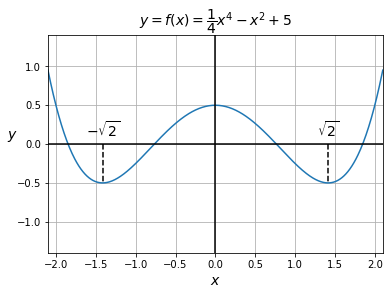

In [ ]:
#@title
def f(x):
  return 1/4 * x**4 - x**2 + 1/2

xs = np.linspace(-2.1, 2.1, 500)
ys = f(xs)
plt.plot(xs, ys)
plt.plot([np.sqrt(2), np.sqrt(2)], [0, f(np.sqrt(2))], "k--")
plt.plot([-np.sqrt(2), -np.sqrt(2)], [0, f(-np.sqrt(2))], "k--")
plt.text(-np.sqrt(2), 0.1, r"$-\sqrt{2}$",
         fontsize=14, horizontalalignment="center")
plt.text(np.sqrt(2), 0.1, r"$\sqrt{2}$",
         fontsize=14, horizontalalignment="center")
show(axis=[-2.1, 2.1, -1.4, 1.4], title=r"$y=f(x)=\dfrac{1}{4}x^4 - x^2 + 5$")

If a function has a local extremum at a point $x_\mathrm{A}$ and is differentiable at that point, then $f'(x_\mathrm{A})=0$. However, the reverse is not always true. For example, consider $f(x)=x^3$. Its derivative is $f'(x)=x^2$, which is equal to 0 at $x_\mathrm{A}=0$. Yet, this point is _not_ an extremum, as you can see on the following diagram. It's just a single point where the slope is 0.

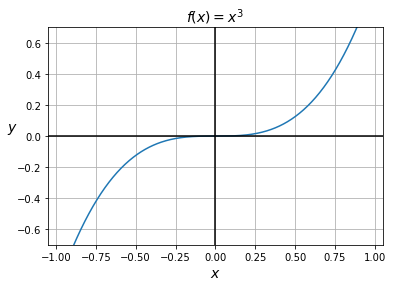

In [ ]:
#@title
def f(x):
  return x**3

xs = np.linspace(-1.05, 1.05, 500)
ys = f(xs)
plt.plot(xs, ys)
show(axis=[-1.05, 1.05, -0.7, 0.7], title=r"$f(x)=x^3$")

So in short, you can optimize a function by analytically working out the points at which the derivative is 0, and then investigating only these points. It's a beautifully elegant solution, but it requires a lot of work, and it's not always easy, or even possible. For neural networks, it's practically impossible.

Another option to optimize a function is to perform **Gradient Descent** (we will consider minimizing the function, but the process would be almost identical if we tried to maximize a function instead): start at a random point $x_0$, then use the function's derivative to determine the slope at that point, and move a little bit in the downwards direction, then repeat the process until you reach a local minimum, and cross your fingers in the hope that this happens to be the global minimum.

At each iteration, the step size is proportional to the slope, so the process naturally slows down as it approaches a local minimum. Each step is also proportional to the learning rate: a parameter of the Gradient Descent algorithm itself (since it is not a parameter of the function we are optimizing, it is called a **hyperparameter**).

Here is an animation of this process on the function $f(x)=\dfrac{1}{4}x^4 - x^2 + \dfrac{1}{2}$:

In [ ]:
#@title
def animate_gradient_descent(f, fp, f_str, x_0):
    learning_rate = 0.01
    n_frames = 200
    x_min, x_max = -1000, 1000

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

    # plot f
    xs = np.linspace(-2.1, 2.1, 500)
    ys = f(xs)
    ax1.plot(xs, ys)

    # plot tangent
    line_tangent, = ax1.plot([x_min, x_max], [0, 0])

    # plot f'
    xs = np.linspace(-2.1, 2.1, 500)
    ys = fp(xs)
    ax2.plot(xs, ys, "r-")

    # plot points A
    point_A1, = ax1.plot(0, 0, "bo")
    point_A2, = ax2.plot(0, 0, "bo")

    show([-2.1, 2.1, -1.4, 1.4], ax=ax1, ylabel="$f(x)$",
        title=r"$y=f(x)=" + f_str + "$ and the tangent at $x=x_\mathrm{A}$")
    show([-2.1, 2.1, -4.2, 4.2], ax=ax2, ylabel="$f'(x)$",
        title=r"$y=f'(x)$ and the slope of the tangent at $x=x_\mathrm{A}$")

    xs = []
    x = x_0
    for index in range(n_frames):
      xs.append(x)
      slope = fp(x)
      x = x - slope * learning_rate

    def update_graph(i):
        x = xs[i]
        f_x = f(x)
        df_dx = fp(x)
        offset = f_x - df_dx * x
        line_tangent.set_data([x_min, x_max],
                              [df_dx * x_min + offset, df_dx * x_max + offset])
        point_A1.set_data(x, f_x)
        point_A2.set_data(x, df_dx)
        return line_tangent, point_A1, point_A2

    anim = animation.FuncAnimation(fig, update_graph,
                                  init_func=lambda: update_graph(0),
                                  frames=n_frames,
                                  interval=20,
                                  blit=True)
    plt.close()
    return anim

def f(x):
  return 1/4 * x**4 - x**2 + 1/2

def fp(x):
  return x**3 - 2*x

animate_gradient_descent(f, fp, r"\dfrac{1}{4}x^4 - x^2 + \dfrac{1}{2}",
                         x_0=1/4)

In this example, we started with $x_0 = \dfrac{1}{4}$, so Gradient Descent "rolled down" towards the minimum value at $x = \sqrt2$. But if we had started at $x_0 = -\dfrac{1}{4}$, it would have gone towards $-\sqrt2$. This illustrates the fact that the initial value is important: depending on $x_0$, the algorithm may converge to a global minimum (hurray!) or to a poor local minimum (boo!) or stay stuck on a plateau, such as a horizontal inflection point (boo!).

There are many variants of the Gradient Descent algorithm, discussed in Chapter 11 of the book. These are the ones we care about in Deep Learning. They all rely on the derivative of the cost function with regards to the model parameters (we will discuss functions with multiple parameters later in this notebook).

# Higher order derivatives

What happens if we try to differentiate the function $f'(x)$? Well, we get the so-called second order derivative, noted $f''(x)$, or $\dfrac{\mathrm{d}^2f}{\mathrm{d}x^2}$. If we repeat the process by differentiating $f''(x)$, we get the third-order derivative $f'''(x)$, or $\dfrac{\mathrm{d}^3f}{\mathrm{d}x^3}$. And we could go on to get higher order derivatives.

What's the intuition behind second order derivatives? Well, since the (first order) derivative represents the instantaneous rate of change of $f$ at each point, the second order derivative represents the instantaneous rate of change of the rate of change itself, in other words, you can think of it as the **acceleration** of the curve: if $f''(x) < 0$, then the curve is accelerating "downwards", if $f''(x) > 0$ then the curve is accelerating "upwards", and if $f''(x) = 0$, then the curve is locally a straight line. Note that a curve could be going upwards (i.e., $f'(x)>0$) but also be accelerating downwards (i.e., $f''(x) < 0$): for example, imagine the path of a stone thrown upwards, as it is being slowed down by gravity (which constantly accelerates the stone downwards).

Deep Learning generally only uses first order derivatives, but you will sometimes run into some optimization algorithms or cost functions based on second order derivatives.

# Partial derivatives

Up to now, we have only considered functions with a single variable $x$. What happens when there are multiple variables? For example, let's start with a simple function with 2 variables: $f(x,y)=\sin(xy)$. If we plot this function, using $z=f(x,y)$, we get the following 3D graph. I also plotted some point $\mathrm{A}$ on the surface, along with two lines I will describe shortly.

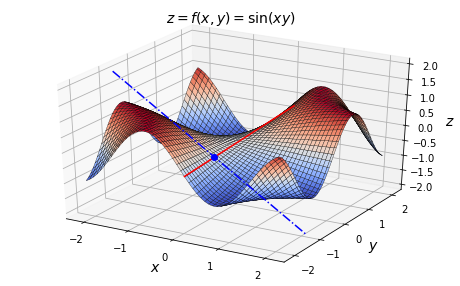

In [ ]:
#@title
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(f, title):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')

    xs = np.linspace(-2.1, 2.1, 100)
    ys = np.linspace(-2.1, 2.1, 100)
    xs, ys = np.meshgrid(xs, ys)
    zs = f(xs, ys)

    surface = ax.plot_surface(xs, ys, zs,
                              cmap=mpl.cm.coolwarm,
                              linewidth=0.3, edgecolor='k')

    ax.set_xlabel("$x$", fontsize=14)
    ax.set_ylabel("$y$", fontsize=14)
    ax.set_zlabel("$z$", fontsize=14)
    ax.set_title(title, fontsize=14)
    return ax

def plot_tangents(ax, x_A, y_A, f, df_dx, df_dy):
    ax.plot3D([x_A], [y_A], f(x_A, y_A), "bo", zorder=10)
    x_min, x_max = -2.1, 2.1
    slope_x = df_dx(x_A, y_A)
    offset_x = f(x_A, y_A) - slope_x * x_A
    ax.plot3D([x_min, x_max], [y_A, y_A],
              [slope_x * x_min + offset_x, slope_x * x_max + offset_x], "b-.",
              zorder=5)
    y_min, y_max = -2.1, 2.1
    slope_y = df_dy(x_A, y_A)
    offset_y = f(x_A, y_A) - slope_y * y_A
    ax.plot3D([x_A, x_A], [y_min, y_max],
              [slope_y * y_min + offset_y, slope_y * y_max + offset_y], "r-",
              zorder=5)

def f(x, y):
    return np.sin(x * y)

def df_dx(x, y):
    return y * np.cos(x * y)

def df_dy(x, y):
    return x * np.cos(x * y)

ax = plot_3d(f, r"$z = f(x, y) = \sin(xy)$")
plot_tangents(ax, 0.1, -1, f, df_dx, df_dy)

plt.show()

If you were to stand on this surface at point $\mathrm{A}$ and walk along the $x$ axis towards the right (increasing $x$), your path would go down quite steeply (along the dashed blue line). The slope along this axis would be negative. However, if you were to walk along the $y$ axis, towards the back (increasing $y$), then your path would almost be flat (along the solid red line), at least locally: the slope along that axis, at point $\mathrm{A}$, would be very slightly positive.

As you can see, a single number is no longer sufficient to describe the slope of the function at a given point. We need one slope for the $x$ axis, and one slope for the $y$ axis. One slope for each variable. To find the slope along the $x$ axis, called the **partial derivative of $f$ with regards to $x$**, and noted $\dfrac{\partial f}{\partial x}$ (with curly $\partial$), we can differentiate $f(x,y)$ with regards to $x$ while treating all other variables (in this case just $y$) as constants:

$ \dfrac{\partial f}{\partial x} = \underset{\epsilon \to 0}\lim\dfrac{f(x+\epsilon, y) - f(x,y)}{\epsilon}$

If you use the derivative rules listed earlier (in this example you would just need the product rule and the chain rule), making sure to treat $y$ as a constant, then you will find:

$ \dfrac{\partial f}{\partial x} = y\cos(xy)$

Similarly, the partial derivative of $f$ with regards to $y$ is defined as:

$ \dfrac{\partial f}{\partial y} = \underset{\epsilon \to 0}\lim\dfrac{f(x, y+\epsilon) - f(x,y)}{\epsilon}$

All variables except for $y$ are treated like constants (just $x$ in this example). Using the derivative rules, we get:

$ \dfrac{\partial f}{\partial y} = x\cos(xy)$

We now have equations to compute the slope along the $x$ axis and along the $y$ axis. But what about the other directions? If you were standing on the surface at point $\mathrm{A}$, you could decide to walk in any direction you choose, not just along the $x$ or $y$ axes. What would the slope be then? Shouldn't we compute the slope along every possible direction?

Well, it can be shown that if all the partial derivatives are defined and continuous in a neighborhood around point $\mathrm{A}$, then the function $f$ is **totally differentiable** at that point, meaning that it can be locally approximated by a plane $P_\mathrm{A}$ (the tangent plane to the surface at point $\mathrm{A}$). In this case, having just the partial derivatives along each axis ($x$ and $y$ in our case) is sufficient to perfectly characterize that plane. Its equation is:

$z = f(x_\mathrm{A},y_\mathrm{A}) + (x - x_\mathrm{A})\dfrac{\partial f}{\partial x}(x_\mathrm{A},y_\mathrm{A}) + (y - y_\mathrm{A})\dfrac{\partial f}{\partial y}(x_\mathrm{A},y_\mathrm{A})$

In Deep Learning, we will generally be dealing with well-behaved functions that are totally differentiable at any point where all the partial derivatives are defined, but you should know that some functions are not that nice. For example, consider the function:

$h(x,y)=\begin{cases}0 \text { if } x=0 \text{ or } y=0\\1 \text { otherwise}\end{cases}$

At the origin (i.e., at $(x,y)=(0,0)$), the partial derivatives of the function $h$ with respect to $x$ and $y$ are both perfectly defined: they are equal to 0. Yet the function can clearly not be approximated by a plane at that point. It is not totally differentiable at that point (but it is totally differentiable at any point off the axes).


# Gradients

So far we have considered only functions with a single variable $x$, or with 2 variables, $x$ and $y$, but the previous paragraph also applies to functions with more variables. So let's consider a function $f$ with $n$ variables: $f(x_1, x_2, \dots, x_n)$. For convenience, we will define a vector $\mathbf{x}$ whose components are these variables:

$\mathbf{x}=\begin{pmatrix}
x_1\\
x_2\\
\vdots\\
x_n
\end{pmatrix}$ 

Now $f(\mathbf{x})$ is easier to write than $f(x_1, x_2, \dots, x_n)$.

The gradient of the function $f(\mathbf{x})$ at some point $\mathbf{x}_\mathrm{A}$ is the vector whose components are all the partial derivatives of the function at that point. It is noted $\nabla f(\mathbf{x}_\mathrm{A})$, or sometimes $\nabla_{\mathbf{x}_\mathrm{A}}f$:

$\nabla f(\mathbf{x}_\mathrm{A}) = \begin{pmatrix}
\dfrac{\partial f}{\partial x_1}(\mathbf{x}_\mathrm{A})\\
\dfrac{\partial f}{\partial x_2}(\mathbf{x}_\mathrm{A})\\
\vdots\\\
\dfrac{\partial f}{\partial x_n}(\mathbf{x}_\mathrm{A})\\
\end{pmatrix}$

Assuming the function is totally differentiable at the point $\mathbf{x}_\mathbf{A}$, then the surface it describes can be approximated by a plane at that point (as discussed in the previous section), and the gradient vector is the one that points towards the steepest slope on that plane.

## Gradient Descent, revisited

In Deep Learning, the Gradient Descent algorithm we discussed earlier is based on gradients instead of derivatives (hence its name). It works in much the same way, but using vectors instead of scalars: simply start with a random vector $\mathbf{x}_0$, then compute the gradient of $f$ at that point, and perform a small step in the opposite direction, then repeat until convergence. More precisely, at each step $t$, compute $\mathbf{x}_t = \mathbf{x}_{t-1} - \eta \nabla f(\mathbf{x}_{t-1})$. The constant $\eta$ is the learning rate, typically a small value such as $10^{-3}$. In practice, we generally use more efficient variants of this algorithm, but the general idea remains the same.

In Deep Learning, the letter $\mathbf{x}$ is generally used to represent the input data. When you _use_ a neural network to make predictions, you feed the neural network the inputs $\mathbf{x}$, and you get back a prediction $\hat{y} = f(\mathbf{x})$. The function $f$ treats the model parameters as constants. We can use more explicit notation by writing $\hat{y} = f_\mathbf{w}(\mathbf{x})$, where $\mathbf{w}$ represents the model parameters and indicates that the function relies on them, but treats them as constants.

However, when _training_ a neural network, we do quite the opposite: all the training examples are grouped in a matrix $\mathbf{X}$, all the labels are grouped in a vector $\mathbf{y}$, and both $\mathbf{X}$ and $\mathbf{y}$ are treated as constants, while $\mathbf{w}$ is treated as variable: specifically, we try to minimize the cost function $\mathcal L_{\mathbf{X}, \mathbf{y}}(\mathbf{w}) = g(f_{\mathbf{X}}(\mathbf{w}), \mathbf{y})$, where $g$ is a function that measures the "discrepancy" between the predictions $f_{\mathbf{X}}(\mathbf{w})$ and the labels $\mathbf{y}$, where $f_{\mathbf{X}}(\mathbf{w})$ represents the vector containing the predictions for each training example. Minimizing the loss function is usually performed using Gradient Descent (or a variant of GD): we start with random model parameters $\mathbf{w}_0$, then we compute $\nabla \mathcal L(\mathbf{w}_0)$ and we use this gradient vector to perform a Gradient Descent step, then we repeat the process until convergence. It is crucial to understand that the gradient of the loss function is with regards to the model parameters $\mathbf{w}$ (_not_ the inputs $\mathbf{x}$).

# Jacobians

Until now we have only considered functions that output a scalar, but it is possible to output vectors instead. For example, a classification neural network typically outputs one probability for each class, so if there are $m$ classes, the neural network will output an $d$-dimensional vector for each input.

In Deep Learning we generally only need to differentiate the loss function, which almost always outputs a single scalar number. But suppose for a second that you want to differentiate a function $\mathbf{f}(\mathbf{x})$ which outputs $d$-dimensional vectors. The good news is that you can treat each _output_ dimension independently of the others. This will give you a partial derivative for each input dimension and each output dimension. If you put them all in a single matrix, with one column per input dimension and one row per output dimension, you get the so-called **Jacobian matrix**.

$
\mathbf{J}_\mathbf{f}(\mathbf{x}_\mathbf{A}) = \begin{pmatrix}
\dfrac{\partial f_1}{\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial f_1}{\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial f_1}{\partial x_n}(\mathbf{x}_\mathbf{A})\\
\dfrac{\partial f_2}{\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial f_2}{\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial f_2}{\partial x_n}(\mathbf{x}_\mathbf{A})\\
\vdots && \vdots && \ddots && \vdots \\
\dfrac{\partial f_m}{\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial f_m}{\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial f_m}{\partial x_n}(\mathbf{x}_\mathbf{A})
\end{pmatrix}
$

The partial derivatives themselves are often called the **Jacobians**. It's just the first order partial derivatives of the function $\mathbf{f}$.

# Hessians

Let's come back to a function $f(\mathbf{x})$ which takes an $n$-dimensional vector as input and outputs a scalar. If you determine the equation of the partial derivative of $f$ with regards to $x_i$ (the $i^\text{th}$ component of $\mathbf{x}$), you will get a new function of $\mathbf{x}$: $\dfrac{\partial f}{\partial x_i}$. You can then compute the partial derivative of this function with regards to $x_j$ (the $j^\text{th}$ component of $\mathbf{x}$). The result is a partial derivative of a partial derivative: in other words, it is a **second order partial derivatives**, also called a **Hessian**. It is noted $\mathbf{x}$: $\dfrac{\partial^2 f}{\partial x_jx_i}$. If $i\neq j$ then it is called a **mixed second order partial derivative**.
Or else, if $j=i$, it is noted $\dfrac{\partial^2 f}{\partial {x_i}^2}$

Let's look at an example: $f(x, y)=\sin(xy)$. As we showed earlier, the first order partial derivatives of $f$ are: $\dfrac{\partial f}{\partial x}=y\cos(xy)$ and $\dfrac{\partial f}{\partial y}=x\cos(xy)$. So we can now compute all the Hessians (using the derivative rules we discussed earlier):

* $\dfrac{\partial^2 f}{\partial x^2} = \dfrac{\partial f}{\partial x}\left[y\cos(xy)\right] = -y^2\sin(xy)$
* $\dfrac{\partial^2 f}{\partial y\,\partial x} = \dfrac{\partial f}{\partial y}\left[y\cos(xy)\right] = \cos(xy) - xy\sin(xy)$
* $\dfrac{\partial^2 f}{\partial x\,\partial y} = \dfrac{\partial f}{\partial x}\left[x\cos(xy)\right] = \cos(xy) - xy\sin(xy)$
* $\dfrac{\partial^2 f}{\partial y^2} = \dfrac{\partial f}{\partial y}\left[x\cos(xy)\right] = -x^2\sin(xy)$

Note that $\dfrac{\partial^2 f}{\partial x\,\partial y} = \dfrac{\partial^2 f}{\partial y\,\partial x}$. This is the case whenever all the partial derivatives are defined and continuous in a neighborhood around the point at which we differentiate.

The matrix containing all the Hessians is called the **Hessian matrix**:

$
\mathbf{H}_f(\mathbf{x}_\mathbf{A}) = \begin{pmatrix}
\dfrac{\partial^2 f}{\partial {x_1}^2}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial x_1\, \partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial^2 f}{\partial x_1\, \partial x_n}(\mathbf{x}_\mathbf{A})\\
\dfrac{\partial^2 f}{\partial x_2\,\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial {x_2}^2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial^2 f}{\partial x_2\, \partial x_n}(\mathbf{x}_\mathbf{A})\\
\vdots && \vdots && \ddots && \vdots \\
\dfrac{\partial^2 f}{\partial x_n\,\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial x_n\,\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial^2 f}{\partial {x_n}^2}(\mathbf{x}_\mathbf{A})\\
\end{pmatrix}
$

There are great optimization algorithms which take advantage of the Hessians, but in practice Deep Learning almost never uses them. Indeed, if a function has $n$ variables, there are $n^2$ Hessians: since neural networks typically have several millions of parameters, the number of Hessians would exceed thousands of billions. Even if we had the necessary amount of RAM, the computations would be prohibitively slow.

## A few proofs

Let's finish by proving all the derivative rules we listed earlier. You don't have to go through all these proofs to be a good Deep Learning practitioner, but it may help you get a deeper understanding of derivatives.

## Constant: $f(x)=c$

$
\begin{split}
f'(x) && = \underset{\epsilon \to 0}\lim\dfrac{f(x+\epsilon) - f(x)}{\epsilon} && \quad\text{by definition}\\
&& = \underset{\epsilon \to 0}\lim\dfrac{c - c}{\epsilon} && \quad \text{using }f(x) = c \\
&& = \underset{\epsilon \to 0}\lim 0 && \quad \text{since }c - c = 0\\
&& = 0 && \quad \text{since the limit of a constant is that constant}
\end{split}
$


## Product rule: $f(x)=g(x)h(x)$

$
\begin{split}
f'(x) && = \underset{\epsilon \to 0}\lim\dfrac{f(x+\epsilon) - f(x)}{\epsilon} && \quad\text{by definition}\\
&& = \underset{\epsilon \to 0}\lim\dfrac{g(x+\epsilon)h(x+\epsilon) - g(x)h(x)}{\epsilon} && \quad \text{using }f(x) = g(x)h(x) \\
&& = \underset{\epsilon \to 0}\lim\dfrac{g(x+\epsilon)h(x+\epsilon) - g(x)h(x+\epsilon) + g(x)h(x + \epsilon) - g(x)h(x)}{\epsilon} && \quad \text{subtracting and adding }g(x)h(x + \epsilon)\\
&& = \underset{\epsilon \to 0}\lim\dfrac{g(x+\epsilon)h(x+\epsilon) - g(x)h(x+\epsilon)}{\epsilon} + \underset{\epsilon \to 0}\lim\dfrac{g(x)h(x + \epsilon) - g(x)h(x)}{\epsilon} && \quad \text{since the limit of a sum is the sum of the limits}\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{g(x+\epsilon) - g(x)}{\epsilon}h(x+\epsilon)\right]} \,+\, \underset{\epsilon \to 0}\lim{\left[g(x)\dfrac{h(x + \epsilon) - h(x)}{\epsilon}\right]} && \quad \text{factorizing }h(x+\epsilon) \text{ and } g(x)\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{g(x+\epsilon) - g(x)}{\epsilon}h(x+\epsilon)\right]} \,+\, g(x)\underset{\epsilon \to 0}\lim{\dfrac{h(x + \epsilon) - h(x)}{\epsilon}} && \quad \text{taking } g(x) \text{ out of the limit since it does not depend on }\epsilon\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{g(x+\epsilon) - g(x)}{\epsilon}h(x+\epsilon)\right]} \,+\, g(x)h'(x) && \quad \text{using the definition of h'(x)}\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{g(x+\epsilon) - g(x)}{\epsilon}\right]}\underset{\epsilon \to 0}\lim{h(x+\epsilon)} + g(x)h'(x) && \quad \text{since the limit of a product is the product of the limits}\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{g(x+\epsilon) - g(x)}{\epsilon}\right]}h(x) + h(x)g'(x) && \quad \text{since } h(x) \text{ is continuous}\\
&& = g'(x)h(x) + g(x)h'(x) && \quad \text{using the definition of }g'(x)
\end{split}
$

Note that if $g(x)=c$ (a constant), then $g'(x)=0$, so the equation simplifies to:

$f'(x)=c \, h'(x)$

## Chain rule: $f(x)=g(h(x))$

$
\begin{split}
f'(x) && = \underset{\epsilon \to 0}\lim\dfrac{f(x+\epsilon) - f(x)}{\epsilon} && \quad\text{by definition}\\
&& = \underset{\epsilon \to 0}\lim\dfrac{g(h(x+\epsilon)) - g(h(x))}{\epsilon} && \quad \text{using }f(x) = g(h(x))\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{h(x+\epsilon)-h(x)}{h(x+\epsilon)-h(x)}\,\dfrac{g(h(x+\epsilon)) - g(h(x))}{\epsilon}\right]} && \quad \text{multiplying and dividing by }h(x+\epsilon) - h(x)\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{h(x+\epsilon)-h(x)}{\epsilon}\,\dfrac{g(h(x+\epsilon)) - g(h(x))}{h(x+\epsilon)-h(x)}\right]} && \quad \text{swapping the denominators}\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{h(x+\epsilon)-h(x)}{\epsilon}\right]} \underset{\epsilon \to 0}\lim{\left[\dfrac{g(h(x+\epsilon)) - g(h(x))}{h(x+\epsilon)-h(x)}\right]} && \quad \text{the limit of a product is the product of the limits}\\
&& = h'(x) \underset{\epsilon \to 0}\lim{\left[\dfrac{g(h(x+\epsilon)) - g(h(x))}{h(x+\epsilon)-h(x)}\right]} && \quad \text{using the definition of }h'(x)\\
&& = h'(x) \underset{\epsilon \to 0}\lim{\left[\dfrac{g(u) - g(v)}{u-v}\right]} && \quad \text{using }u=h(x+\epsilon) \text{ and } v=h(x)\\
&& = h'(x) \underset{u \to v}\lim{\left[\dfrac{g(u) - g(v)}{u-v}\right]} && \quad \text{ since } h \text{ is continuous, so } \underset{\epsilon \to 0}\lim{u}=v\\
&& = h'(x)g'(v) && \quad \text{ using the definition of } g'(v)\\
&& = h'(x)g'(h(x)) && \quad \text{ since } v = h(x)
\end{split}
$

## Exponential: $f(x)=\exp(x)=e^x$

There are several equivalent definitions of the number $e$. One of them states that $e$ is the unique positive number for which $\underset{\epsilon \to 0}\lim{\dfrac{e^\epsilon - 1}{\epsilon}}=1$. We will use this in this proof:

$
\begin{split}
f'(x) && = \underset{\epsilon \to 0}\lim\dfrac{f(x+\epsilon) - f(x)}{\epsilon} && \quad\text{by definition}\\
&& = \underset{\epsilon \to 0}\lim\dfrac{e^{x+\epsilon} - e^x}{\epsilon} && \quad \text{using }f(x) = e^x\\
&& = \underset{\epsilon \to 0}\lim\dfrac{e^x e^\epsilon - e^x}{\epsilon} && \quad \text{using the fact that } x^{a+b}=x^a x^b\\
&& = \underset{\epsilon \to 0}\lim{\left[e^x\dfrac{e^\epsilon - 1}{\epsilon}\right]} && \quad \text{factoring out }e^x\\
&& = \underset{\epsilon \to 0}\lim{e^x} \, \underset{\epsilon \to 0}\lim{\dfrac{e^\epsilon - 1}{\epsilon}} && \quad \text{the limit of a product is the product of the limits}\\
&& = \underset{\epsilon \to 0}\lim{e^x} && \quad \text{since }\underset{\epsilon \to 0}\lim{\dfrac{e^\epsilon - 1}{\epsilon}}=1\\
&& = e^x && \quad \text{since } e^x \text{ does not depend on }\epsilon
\end{split}
$


## Logarithm: $f(x) = \ln(x)$

Another definition of the number $e$ is:

$e = \underset{n \to \infty}\lim\left(1+\dfrac{1}{n}\right)^n$

By defining $\epsilon = \dfrac{1}{n}$, we can rewrite the previous definition as:

$e = \underset{\epsilon \to 0}\lim\left(1+\epsilon\right)^{1/\epsilon}$

This will come in handy in a second:

$
\begin{split}
f'(x) && = \underset{\epsilon \to 0}\lim\dfrac{f(x+\epsilon) - f(x)}{\epsilon} && \quad\text{by definition}\\
&& = \underset{\epsilon \to 0}\lim\dfrac{\ln(x+\epsilon) - \ln(x)}{\epsilon} && \quad \text{using }f(x) = \ln(x)\\
&& = \underset{\epsilon \to 0}\lim\dfrac{\ln\left(\dfrac{x+\epsilon}{x}\right)}{\epsilon} && \quad \text{since }\ln(a)-\ln(b)=\ln\left(\dfrac{a}{b}\right)\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{1}{\epsilon} \, \ln\left(1 + \dfrac{\epsilon}{x}\right)\right]} && \quad \text{just moving things around a bit}\\
&& = \underset{\epsilon \to 0}\lim{\left[\dfrac{1}{xu} \, \ln\left(1 + u\right)\right]} && \quad \text{defining }u=\dfrac{\epsilon}{x} \text{ and thus } \epsilon=xu\\
&& = \underset{u \to 0}\lim{\left[\dfrac{1}{xu} \, \ln\left(1 + u\right)\right]} && \quad \text{replacing } \underset{\epsilon \to 0}\lim \text{ with } \underset{u \to 0}\lim \text{ since }\underset{\epsilon \to 0}\lim u=0\\
&& = \underset{u \to 0}\lim{\left[\dfrac{1}{x} \, \ln\left((1 + u)^{1/u}\right)\right]} && \quad \text{since }a\ln(b)=\ln(a^b)\\
&& = \dfrac{1}{x}\underset{u \to 0}\lim{\left[\ln\left((1 + u)^{1/u}\right)\right]} && \quad \text{taking }\dfrac{1}{x} \text{ out since it does not depend on }\epsilon\\
&& = \dfrac{1}{x}\ln\left(\underset{u \to 0}\lim{(1 + u)^{1/u}}\right) && \quad \text{taking }\ln\text{ out since it is a continuous function}\\
&& = \dfrac{1}{x}\ln(e) && \quad \text{since }e=\underset{u \to 0}\lim{(1 + u)^{1/u}}\\
&& = \dfrac{1}{x} && \quad \text{since }\ln(e)=1
\end{split}
$


## Power rule: $f(x)=x^r$, with $r \neq 0$

Let's define $g(x)=e^x$ and $h(x)=\ln(x^r)$. Since $a = e^{\ln(a)}$, we can rewrite $f$ as $f(x)=g(h(x))$, which allows us to use the chain rule:

$f'(x) = h'(x)g'(h(x))$

We know the derivative of the exponential: $g'(x)=e^x$. We also know the derivative of the natural logarithm: $\ln'(x)=\dfrac{1}{x}$ so $h'(x)=\dfrac{r}{x}$. Therefore:

$f'(x) = \dfrac{r}{x}\exp\left({\ln(x^r)}\right)$

Since $a = \exp(\ln(a))$, this equation simplifies to:

$f'(x) = \dfrac{r}{x} x^r$

And finally:

$f'(x) = rx^{r - 1}$

Note that the power rule works for any $r \neq 0$, including negative numbers and real numbers. For example:

* if $f(x) = \dfrac{1}{x} = x^{-1}$, then $f'(x)=-x^{-2}=-\dfrac{1}{x^2}$.
* if $f(x) = \sqrt(x) = x^{1/2}$, then $f'(x)=\dfrac{1}{2}x^{-1/2}=\dfrac{1}{2\sqrt{x}}$

## Multiplicative inverse: $f(x)=\dfrac{1}{h(x)}$
First, let's define $g(x) = \dfrac{1}{x}$. This leads to $f(x)=g(h(x))$.
Now we can use the chain rule:

$f'(x) = h'(x)g'(h(x))$

Since $g(x)=x^{-1}$, we can use the power rule to find $g'(x)=-\dfrac{1}{x^2}$

Finally, we get:

$f'(x) = -\dfrac{h'(x)}{h^2(x)}$

## Quotient rule: $f(x)=\dfrac{g(x)}{h(x)}$

Let's rewrite $f(x)$ as a product: $f(x)=g(x)u(x)$ with $u(x)=\dfrac{1}{h(x)}$

We can now use the product rule to get:

$f(x) = g'(x)u(x) + g(x)u'(x)$

Replacing $u(x)$ with $\dfrac{1}{h(x)}$ and using the result of the previous section to replace $u'(x)$ with $\dfrac{-h'(x)}{h^2(x)}$, we get:

$f(x) = g'(x)\dfrac{1}{h(x)} + g(x)\dfrac{-h'(x)}{h^2(x)}$

Now we multiply and divide the first term by $h(x)$:

$f(x) = \dfrac{g'(x)h(x)}{h^2(x)} - \dfrac{g(x)h'(x)}{h^2(x)}$

And finally:

$f(x) = \dfrac{g'(x)h(x) - g(x)h'(x)}{h^2(x)}$

## Sin: $f(x)=\sin(x)$

For this proof we will first need to prove that $\underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta}=1$. One way to do that is to consider the following diagram:



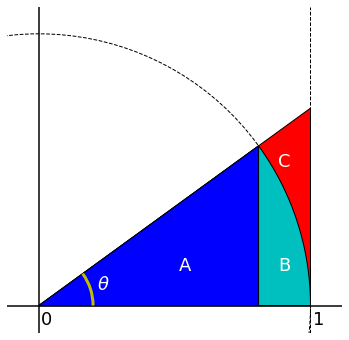

In [ ]:
#@title
angle = np.pi/5
A_pos = [np.cos(angle), np.sin(angle)]

fig, ax = plt.subplots(figsize=(6, 6))

from functools import partial
ax_text = partial(ax.text, color="w", fontsize=18, zorder=4,
                  horizontalalignment='center', verticalalignment='center')

circle = plt.Circle((0, 0), 1,
                    zorder=0, facecolor='w', edgecolor='k', linestyle="--")
triangle1 = plt.Polygon([[0, 0], [1, np.tan(angle)], [1, 0]],
                        zorder=1, facecolor='r', edgecolor='k')
arc_points = np.array([[0, 0]] + [[np.cos(a), np.sin(a)] 
              for a in np.linspace(0, angle, 50)])
ax.fill(arc_points[:, 0], arc_points[:, 1],
        zorder=2, facecolor='c', edgecolor='k')
triangle2 = plt.Polygon([[0, 0], A_pos, [A_pos[0], 0]],
                        zorder=3, facecolor='b', edgecolor='k')
ax_text(2*np.cos(angle)/3, np.sin(angle)/4, "A")
ax_text((1+np.cos(angle))/2, np.sin(angle)/4, "B")
ax_text((1+np.cos(angle))/2, 0.9*np.sin(angle), "C")
ax_text(0.25*np.cos(angle/2), 0.25*np.sin(angle/2), r"$\theta$")
arc = mpl.patches.Arc([0, 0], 2*0.2, 2*0.2, theta1=0, theta2=angle*180/np.pi,
                      zorder=5, color='y', linewidth=3)
ax_text(0.03, -0.05, "0", color='k')
ax_text(1.03, -0.05, "1", color='k')

ax.axhline(y=0, color='k', zorder=4)
ax.axvline(x=0, color='k', zorder=4)
ax.axvline(x=1, color='k', zorder=4, linewidth=1, linestyle='--')
ax.axis('equal')
ax.axis([-0.1, 1.1, -0.1, 1.1])
ax.axis('off')
ax.add_artist(circle)
ax.add_artist(triangle1)
ax.add_artist(triangle2)
ax.add_patch(arc)
plt.show()

The circle is the unit circle (radius=1).

Assuming $0 < \theta < \dfrac{\pi}{2}$, the area of the blue triangle (area $\mathrm{A}$) is equal to its height ($\sin(\theta)$), times its base ($\cos(\theta)$), divided by 2. So $\mathrm{A} = \dfrac{1}{2}\sin(\theta)\cos(\theta)$.

The unit circle has an area of $\pi$, so the circular sector (in the shape of a pizza slice) has an area of A + B = $\pi\dfrac{\theta}{2\pi} = \dfrac{\theta}{2}$.

Next, the large triangle (A + B + C) has an area equal to its height ($\tan(\theta)$) multiplied by its base (1) divided by 2, so A + B + C = $\dfrac{\tan(\theta)}{2}$.

When $0 < \theta < \dfrac{\pi}{2}$, we have $\mathrm{A} < \mathrm{A} + \mathrm{B} < \mathrm{A} + \mathrm{B} + \mathrm{C}$, therefore:

$\dfrac{1}{2}\sin(\theta)\cos(\theta) < \dfrac{\theta}{2} < \dfrac{\tan(\theta)}{2}$

We can multiply all the terms by 2 to get rid of the $\dfrac{1}{2}$ factors. We can also divide by $\sin(\theta)$, which is stricly positive (assuming $0 < \theta < \dfrac{\pi}{2}$), so the inequalities still hold:

$cos(\theta) < \dfrac{\theta}{\sin(\theta)} < \dfrac{\tan(\theta)}{\sin(\theta)}$

Recall that $\tan(\theta)=\dfrac{\sin(\theta)}{\cos(\theta)}$, so the last term simplifies like so:

$cos(\theta) < \dfrac{\theta}{\sin(\theta)} < \dfrac{1}{\cos(\theta)}$

Since all these terms are strictly positive when $0 < \theta < \dfrac{\pi}{2}$, we can take their inverse and change the direction of the inequalities:

<hr />

**Inequalities (1)**

$\dfrac{1}{cos(\theta)} > \dfrac{\sin(\theta)}{\theta} > \cos(\theta)$

assuming $0 < \theta < \dfrac{\pi}{2}$
<hr />

Now since $\sin(-\theta)=-\sin(\theta)$, we see that $\dfrac{\sin(-\theta)}{-\theta}=\dfrac{\sin(\theta)}{\theta}$. Moreover, $\cos(-\theta)=\cos(\theta)$, and therefore $\dfrac{1}{\cos(-\theta)}=\dfrac{1}{\cos(\theta)}$. Replacing the terms in the inequalities (1), we get:

$\dfrac{1}{cos(-\theta)} > \dfrac{\sin(-\theta)}{-\theta} > \cos(-\theta)$

assuming $0 < \theta < \dfrac{\pi}{2}$

In other words, the inequalities (1) also hold for $-\dfrac{\pi}{2} < \theta < 0$:

<hr />

**Inequalities (2)**

$\dfrac{1}{cos(\theta)} > \dfrac{\sin(\theta)}{\theta} > \cos(\theta)$

assuming $-\dfrac{\theta}{2} < \theta < \dfrac{\pi}{2}$ and $\theta \neq 0$
<hr />

Since $\cos$ is a continuous function, $\underset{\theta \to 0}\lim\cos(\theta)=\cos(0)=1$. Similarly, $\underset{\theta \to 0}\lim\dfrac{1}{cos(\theta)}=\dfrac{1}{\cos(0)}=1$.

Since the inequalities (2) tell us that $\dfrac{\sin(\theta)}{\theta}$ is squeezed between $\dfrac{1}{cos(\theta)}$ and $\cos(\theta)$ when $\theta$ is close to 0, and since both of these approach 1 when $\theta$ approaches 0, we can use the **squeeze theorem** (also called the **sandwich theorem**) to conclude that $\dfrac{\sin(\theta)}{\theta}$ must also approach 1 when $\theta$ approaches 0.

<hr />

We have proven that:

$\underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta}=1$

<hr />

Now the second thing we need to prove before we can tackle the derivative of the $\sin$ function is the fact that $\underset{\theta \to 0}\lim\dfrac{\cos(\theta) - 1}{\theta}=0$. Here we go:

$
\begin{split}
\underset{\theta \to 0}\lim\dfrac{\cos(\theta) - 1}{\theta} && =  \underset{\theta \to 0}\lim\dfrac{\cos(\theta) - 1}{\theta}\frac{\cos(\theta) + 1}{\cos(\theta) + 1} && \quad \text{ multiplying and dividing by }\cos(\theta)+1\\
&& =  \underset{\theta \to 0}\lim\dfrac{\cos^2(\theta) - 1}{\theta(\cos(\theta) + 1)} && \quad \text{ since }(a-1)(a+1)=a^2-1\\
&& =  \underset{\theta \to 0}\lim\dfrac{\sin^2(\theta)}{\theta(\cos(\theta) + 1)} && \quad \text{ since }\cos^2(\theta) - 1 = \sin^2(\theta)\\
&& =  \underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta}\dfrac{\sin(\theta)}{\cos(\theta) + 1} && \quad \text{ just rearranging the terms}\\
&& =  \underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta} \, \underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\cos(\theta) + 1} && \quad \text{ since the limit of a product is the product of the limits}\\
&& =  \underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\cos(\theta) + 1} && \quad \text{ since } \underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta}=1\\
&& =  \dfrac{0}{1+1} && \quad \text{ since } \underset{\theta \to 0}\lim\sin(\theta)=0 \text{ and } \underset{\theta \to 0}\lim\cos(\theta)=1\\
&& =  0\\
\end{split}
$

<hr />

We have proven that:

$\underset{\theta \to 0}\lim\dfrac{\cos(\theta) - 1}{\theta}=0$

<hr />

With all that, we are finally ready to prove the fact that the derivative of the $\sin$ function is the $\cos$ function:

$
\begin{split}
f'(x) && = \underset{\theta \to 0}\lim\dfrac{f(x+\theta) - f(x)}{\theta} && \quad\text{by definition}\\
&& = \underset{\theta \to 0}\lim\dfrac{\sin(x+\theta) - \sin(x)}{\theta} && \quad \text{using }f(x) = \sin(x)\\
&& = \underset{\theta \to 0}\lim\dfrac{\cos(x)\sin(\theta) + \sin(x)\cos(\theta) - \sin(x)}{\theta} && \quad \text{since } cos(a+b)=\cos(a)\sin(b)+\sin(a)\cos(b)\\
&& = \underset{\theta \to 0}\lim\dfrac{\cos(x)\sin(\theta)}{\theta} + \underset{\theta \to 0}\lim\dfrac{\sin(x)\cos(\theta) - \sin(x)}{\theta} && \quad \text{since the limit of a sum is the sum of the limits}\\
&& = \cos(x)\underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta} + \sin(x)\underset{\theta \to 0}\lim\dfrac{\cos(\theta) - 1}{\theta} && \quad \text{bringing out } \cos(x) \text{ and } \sin(x) \text{ since they don't depend on }\theta\\
&& = \cos(x)\underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta} && \quad \text{since }\underset{\theta \to 0}\lim\dfrac{\cos(\theta) - 1}{\theta}=0\\
&& = \cos(x) && \quad \text{since }\underset{\theta \to 0}\lim\dfrac{\sin(\theta)}{\theta}=1\\
\end{split}
$


## Cosine: $f(x)=\cos(x)$

Since we have proven that $\sin'(x)=\cos(x)$, proving that $\cos'(x)=-\sin(x)$ will be much easier.

$
\begin{split}
f'(x) && = \underset{\theta \to 0}\lim\dfrac{f(x+\theta) - f(x)}{\theta} && \quad\text{by definition}\\
&& = \underset{\theta \to 0}\lim\dfrac{\cos(x+\theta) - \cos(x)}{\theta} && \quad \text{using }f(x) = \cos(x)\\
&& = \underset{\theta \to 0}\lim\dfrac{\sin\left(x+\dfrac{\pi}{2}+\theta\right) - \sin\left(x+\dfrac{\pi}{2}\right)}{\theta} && \quad \text{since }\cos(x) = \sin\left(x+\dfrac{\pi}{2}\right)\\
&& = \underset{\theta \to 0}\lim\dfrac{\sin(z+\theta) - \sin(z)}{\theta} && \quad \text{using }z = x + \dfrac{\pi}{2}\\
&& = \sin'(z) && \quad \text{using the definition of }\sin'(z)\\
&& = \cos(z) && \quad \text{since we proved that }\sin'(z)=\cos(z)\\
&& = \cos\left(x + \dfrac{\pi}{2}\right) && \quad \text{using the definition of }z\\
&& = -\sin(x) && \quad \text{using this well-known rule of trigonometry}
\end{split}
$


## Tangent: $f(x) = \tan(x)$

Since $\tan(x)=\dfrac{\sin(x)}{\cos(x)}$, we can use the quotient rule to get:

$f'(x) = \dfrac{\sin'(x)\cos(x) - \sin(x)\cos'(x)}{\cos^2(x)}$

Since $\sin'(x)=\cos(x)$ and $\cos'(x)=-\sin(x)$, we get:

$f'(x) = \dfrac{\cos^2(x) + \sin^2(x)}{\cos^2(x)}$

And finally, since $\cos^2(x) + \sin^2(x) = 1$, we get:

$f'(x) = \dfrac{1}{\cos^2(x)}$
